<a href="https://colab.research.google.com/github/quocbao271207/ABC_challenge_2026_test/blob/main/testABC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT THƯ VIỆN

In [21]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


MOUNT GOOGLE DRIVE VÀ ĐỌC FILE

In [22]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/ABCCC/Processed_data_shrink"

train_files = sorted(glob.glob(os.path.join(DATA_DIR, "1_*.csv")))
test_files  = sorted(glob.glob(os.path.join(DATA_DIR, "2_*.csv")))

print("Train files:", train_files)
print("Test  files:", test_files)

participant_map = {
    "1_sbj_0.csv": 0,
    "1_sbj_1.csv": 1,
    "1_sbj_2.csv": 2,
    "1_sbj_0_2.csv": 3
}

def load_multiple_with_participant(files):
    dfs = []
    for f in files:
        base = os.path.basename(f)

        # gọi tên trực tiếp
        p_id = participant_map.get(base, -1)

        df = pd.read_csv(f)
        df["participant"] = p_id
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)
df_train = load_multiple_with_participant(train_files)
df_test  = load_multiple_with_participant(test_files)

print(df_train["participant"].unique())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train files: ['/content/drive/MyDrive/ABCCC/Processed_data_shrink/1_sbj_0.csv', '/content/drive/MyDrive/ABCCC/Processed_data_shrink/1_sbj_0_2.csv', '/content/drive/MyDrive/ABCCC/Processed_data_shrink/1_sbj_1.csv', '/content/drive/MyDrive/ABCCC/Processed_data_shrink/1_sbj_2.csv']
Test  files: ['/content/drive/MyDrive/ABCCC/Processed_data_shrink/2_sbj_0.csv', '/content/drive/MyDrive/ABCCC/Processed_data_shrink/2_sbj_0_2.csv', '/content/drive/MyDrive/ABCCC/Processed_data_shrink/2_sbj_1.csv', '/content/drive/MyDrive/ABCCC/Processed_data_shrink/2_sbj_2.csv']
[0 3 1 2]


LABEL ENCODING

In [23]:
encode_label = {
    'jogging': 1,
    'jogging (rotating arms)': 2,
    'jogging (skipping)': 3,
    'jogging (sidesteps)': 4,
    'jogging (butt-kicks)': 5,
    'stretching (triceps)': 6,
    'stretching (lunging)': 7,
    'stretching (shoulders)': 8,
    'stretching (hamstrings)': 9,
    'stretching (lumbar rotation)': 10,
    'push-ups': 11,
    'push-ups (complex)': 12,
    'sit-ups': 13,
    'sit-ups (complex)': 14,
    'burpees': 15,
    'lunges': 16,
    'lunges (complex)': 17,
    'bench-dips': 18
}

df_train["label"] = df_train["label"].map(encode_label).fillna(0).astype(int)
df_test["label"]  = df_test["label"].map(encode_label).fillna(0).astype(int)


In [24]:
mapped_train = df_train["label"]
mapped_test  = df_test["label"]
print("Mapped train:", pd.Series(mapped_train).unique()[:30])
print("Mappe test:", pd.Series(mapped_test).unique()[:30])

Mapped train: [ 0  1  6  2  7  3 11 12  4  8 13  9 14 16 15 10  5 18 17]
Mappe test: [ 0  1  6  2  7  3 11 12  4  8 13  9 14 16 15 10  5 18 17]


EDA


=== SHAPE ===
Train: (284438, 8) Test: (284438, 8)

=== HEAD ===
   leg_acc_x  leg_acc_y  leg_acc_z  arm_acc_x  arm_acc_y  arm_acc_z  label  \
0   0.978287  -0.111472   0.103445  -0.956057  -0.407509  -0.090828      0   
1   0.982915  -0.095342   0.083391  -1.167835  -0.088288  -0.131609      0   
2   0.977757  -0.124765   0.113024  -1.063969   0.080970  -0.140224      0   
3   0.988421  -0.056063   0.134405  -0.956582   0.273206  -0.157955      0   
4   0.983513  -0.091392   0.095917  -0.927767   0.462559  -0.206675      0   

   participant  
0            0  
1            0  
2            0  
3            0  
4            0  

=== DTYPE SUMMARY ===
leg_acc_x      float64
leg_acc_y      float64
leg_acc_z      float64
arm_acc_x      float64
arm_acc_y      float64
arm_acc_z      float64
label            int64
participant      int64
dtype: object

=== MISSING VALUES ===
leg_acc_x      0
leg_acc_y      0
leg_acc_z      0
arm_acc_x      0
arm_acc_y      0
arm_acc_z      0
label          0

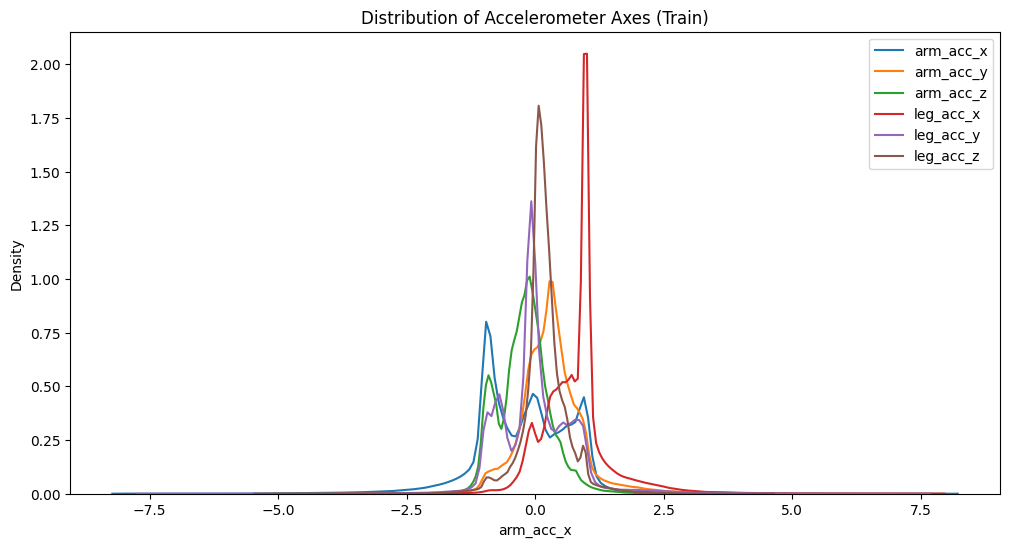

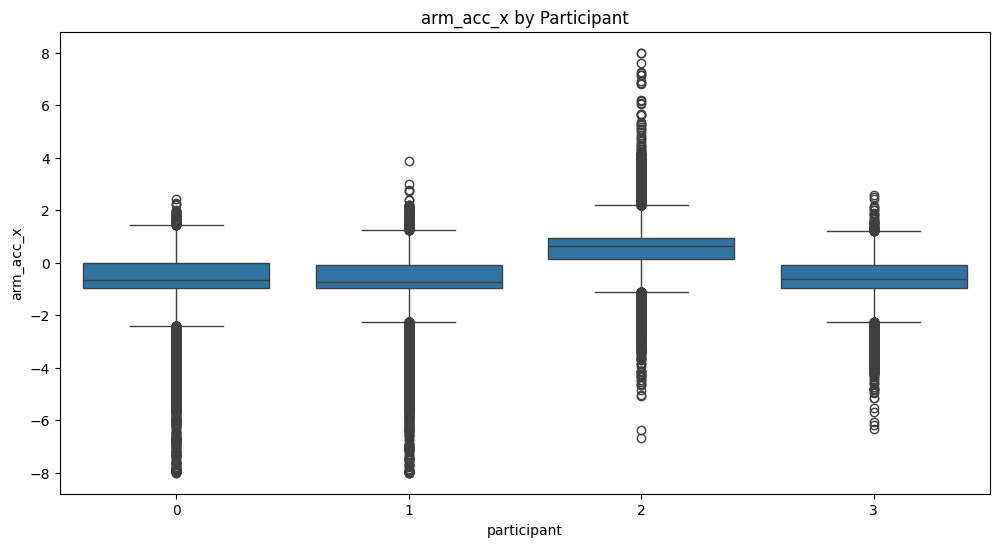

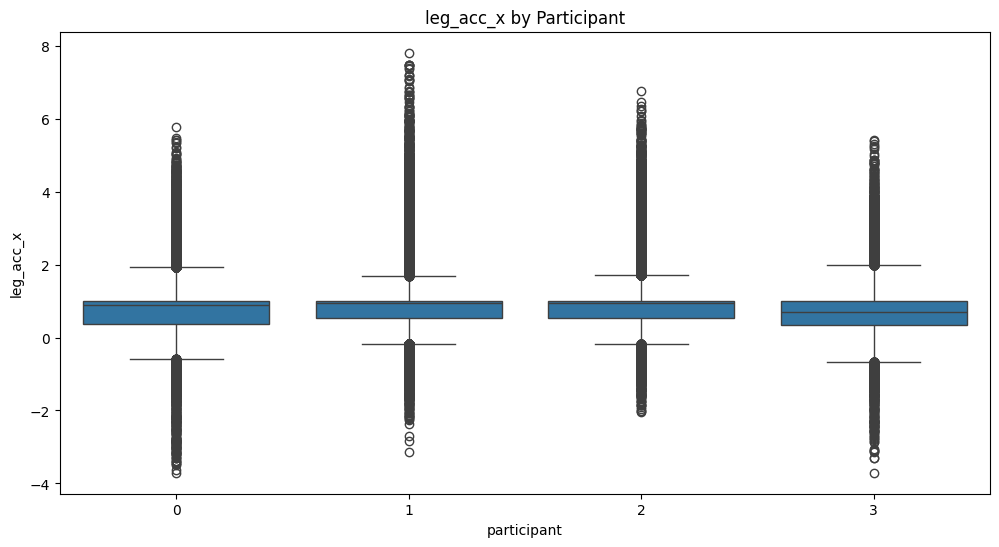


=== OUTLIER COUNT (Z-score > 3) ===
arm_acc_x    3594
arm_acc_y    4693
arm_acc_z    2585
leg_acc_x    4884
leg_acc_y    4873
leg_acc_z    5444
dtype: int64


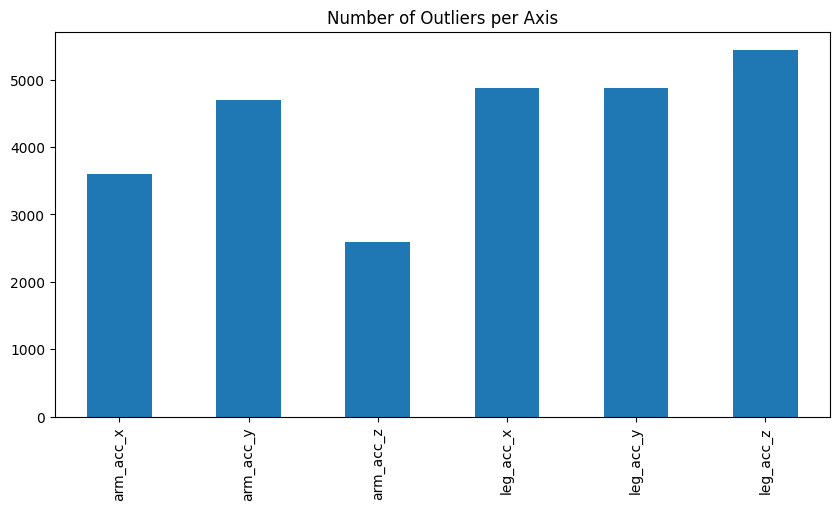

In [25]:
print("\n=== SHAPE ===")
print("Train:", df_train.shape, "Test:", df_test.shape)

print("\n=== HEAD ===")
print(df_train.head())

print("\n=== DTYPE SUMMARY ===")
print(df_train.dtypes)

print("\n=== MISSING VALUES ===")
print(df_train.isna().sum())


# ----------------------------
# 1. SUMMARY STATISTICS
# ----------------------------
numeric_cols = [
    "arm_acc_x","arm_acc_y","arm_acc_z",
    "leg_acc_x","leg_acc_y","leg_acc_z"
]

print("\n=== DESCRIPTIVE STATISTICS (TRAIN) ===")
print(df_train[numeric_cols].describe())

# ----------------------------
# 2. DISTRIBUTION PLOT
# ----------------------------
plt.figure(figsize=(12, 6))
for col in numeric_cols:
    sns.kdeplot(df_train[col], label=col)
plt.title("Distribution of Accelerometer Axes (Train)")
plt.legend()
plt.show()

# ----------------------------
# 3. PARTICIPANT COMPARISON
# ----------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train, x="participant", y="arm_acc_x")
plt.title("arm_acc_x by Participant")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train, x="participant", y="leg_acc_x")
plt.title("leg_acc_x by Participant")
plt.show()

# ----------------------------
# 4. OUTLIER CHECK (Z-score)
# ----------------------------
df_z = df_train[numeric_cols].apply(lambda x: np.abs((x - x.mean()) / x.std()))
outlier_count = (df_z > 3).sum()

print("\n=== OUTLIER COUNT (Z-score > 3) ===")
print(outlier_count)

plt.figure(figsize=(10, 5))
outlier_count.plot(kind='bar')
plt.title("Number of Outliers per Axis")
plt.show()


In [26]:
def acc_table(df, encode_label):
    axes = [
        "arm_acc_x", "arm_acc_y", "arm_acc_z",
        "leg_acc_x", "leg_acc_y", "leg_acc_z"
    ]
    decode_label = {v: k for k, v in encode_label.items()}
    g = (
        df.groupby(["label", "participant"])[axes]
          .mean()
          .reset_index()
    )

    action_tables = {}

    for label_id, action_name in decode_label.items():
        df_action = g[g["label"] == label_id].drop(columns=["label"])
        action_tables[action_name] = df_action
    return action_tables

action_tables = acc_table(df_train, encode_label)

for action, table in action_tables.items():
    print(f"\n ACTION: {action}")
    print(table)



 ACTION: jogging
   participant  arm_acc_x  arm_acc_y  arm_acc_z  leg_acc_x  leg_acc_y  \
4            0  -0.398124   1.070705   0.509917   1.176822   0.374462   
5            1  -1.636010   1.088242  -0.033288   1.291005   0.210508   
6            2   0.739418   0.891944   0.006639   1.349197   0.530869   
7            3  -0.500686   1.088364   0.491410   1.208283   0.268998   

   leg_acc_z  
4   0.483474  
5   0.422901  
6   0.155420  
7   0.464199  

 ACTION: jogging (rotating arms)
    participant  arm_acc_x  arm_acc_y  arm_acc_z  leg_acc_x  leg_acc_y  \
8             0  -0.636869   0.898991   0.271853   1.166534   0.350297   
9             1  -1.641761   0.491693  -0.158630   1.236135   0.233871   
10            3  -0.844228   0.735423   0.151195   1.137093   0.333509   

    leg_acc_z  
8    0.478229  
9    0.318039  
10   0.439492  

 ACTION: jogging (skipping)
    participant  arm_acc_x  arm_acc_y  arm_acc_z  leg_acc_x  leg_acc_y  \
11            0  -1.378137   0.185919   0.1

Dữ liệu cho thấy participant 2 bị đảo dấu trục arm_acc_x, vì toàn bộ giá trị của biến này đều mang chiều ngược lại so với các participant khác trong mọi hoạt động. Trong khi đó, các trục arm_acc_y, arm_acc_z và toàn bộ leg_acc đều bình thường, chứng tỏ chỉ riêng cảm biến tay của P2 bị gắn sai hướng.

ĐỔI CHIỀU TRỤC arm_acc_x CỦA PARTICIPANT 2

In [27]:
df_train_later = df_train.copy()
# test giữ nguyên

target_p = 2

df_train_later.loc[df_train_later["participant"] == target_p, "arm_acc_x"] *= -1

print("==> Đã tạo df_train_later với arm_acc_x participant 2 được đảo dấu")
print(df_train_later[df_train_later["participant"] == 2].head())


==> Đã tạo df_train_later với arm_acc_x participant 2 được đảo dấu
        leg_acc_x  leg_acc_y  leg_acc_z  arm_acc_x  arm_acc_y  arm_acc_z  \
195338   0.994910   0.007139   0.037808  -0.968862   0.325318  -0.115737   
195339   0.991237   0.007256   0.042411  -0.963690   0.323623  -0.114539   
195340   0.991505   0.003956   0.032529  -0.963269   0.318444  -0.119048   
195341   0.991728   0.007812   0.039015  -0.966648   0.317554  -0.116404   
195342   0.993372   0.011200   0.043431  -0.970703   0.319614  -0.116280   

        label  participant  
195338      0            2  
195339      0            2  
195340      0            2  
195341      0            2  
195342      0            2  


TRÍCH XUẤT FEATURES THEO CỬA SỔ

In [28]:
def extract_features_fast(df, window_size=50, overlap=20):
    features = []
    step = window_size - overlap

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for start in range(0, len(df) - window_size + 1, step):
        window = df.iloc[start:start + window_size]
        feat = []
        for col in numeric_cols:
            w = window[col]
            feat.extend([w.mean(), w.std(), w.min(), w.max()])
        features.append(feat)

    return np.array(features)


LẤY LABEL CHO TỪNG WINDOW

In [29]:
def get_windowed_labels_fast(df, window_size=50, overlap=20, label_col="label"):
    labels = []
    step = window_size - overlap
    for start in range(0, len(df) - window_size + 1, step):
        window = df.iloc[start:start + window_size]
        labels.append(window[label_col].mode()[0])
    return np.array(labels)

TẠO X_train, y_train, X_test, y_test


In [30]:
window_size = 50
overlap = 20

X_train = extract_features_fast(df_train_later, window_size, overlap)
y_train = get_windowed_labels_fast(df_train_later, window_size, overlap)

X_test = extract_features_fast(df_test, window_size, overlap=0)
y_test = get_windowed_labels_fast(df_test, window_size, overlap=0)

print("Raw windows — Train:", X_train.shape, "Test:", X_test.shape)


Raw windows — Train: (9480, 32) Test: (5688, 32)


SHUFFLE & SPLIT

In [31]:
# FIX 1 — SHUFFLE trước khi split
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# FIX 2 — Stratify split (giữ đủ lớp)
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print("TRAIN labels:", np.unique(y_train_split))
print("VALID labels:", np.unique(y_valid))
print("TEST  labels:", np.unique(y_test))

# FIX 3 — Đếm số lớp thật sự
n_classes = len(np.unique(y_train))
print("Số lớp thật sự:", n_classes)


TRAIN labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
VALID labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
TEST  labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Số lớp thật sự: 19


TRAINING XGBOOST

In [32]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=n_classes,
    n_estimators=80,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

print("\n=== Training model ===")
model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_train_split, y_train_split), (X_valid, y_valid)],
    verbose=True
)





=== Training model ===
[0]	validation_0-mlogloss:2.10070	validation_1-mlogloss:2.10827
[1]	validation_0-mlogloss:1.73578	validation_1-mlogloss:1.75176
[2]	validation_0-mlogloss:1.48512	validation_1-mlogloss:1.50366
[3]	validation_0-mlogloss:1.29249	validation_1-mlogloss:1.31422
[4]	validation_0-mlogloss:1.13750	validation_1-mlogloss:1.16177
[5]	validation_0-mlogloss:1.00815	validation_1-mlogloss:1.03371
[6]	validation_0-mlogloss:0.89816	validation_1-mlogloss:0.92557
[7]	validation_0-mlogloss:0.80268	validation_1-mlogloss:0.83153
[8]	validation_0-mlogloss:0.71944	validation_1-mlogloss:0.74884
[9]	validation_0-mlogloss:0.64680	validation_1-mlogloss:0.67643
[10]	validation_0-mlogloss:0.58271	validation_1-mlogloss:0.61275
[11]	validation_0-mlogloss:0.52557	validation_1-mlogloss:0.55565
[12]	validation_0-mlogloss:0.47483	validation_1-mlogloss:0.50509
[13]	validation_0-mlogloss:0.42908	validation_1-mlogloss:0.45885
[14]	validation_0-mlogloss:0.38813	validation_1-mlogloss:0.41756
[15]	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=-1, num_class=19, ...)

EVALUATION

In [33]:
y_valid_pred = model.predict(X_valid)
y_test_pred  = model.predict(X_test)

print("\n=== Results ===")
print("Valid Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("\n=== Test Classification Report ===")
print(classification_report(y_test, y_test_pred))



=== Results ===
Valid Accuracy: 0.9968354430379747
Test Accuracy : 0.8321026722925458

=== Test Classification Report ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1854
           1       1.00      0.83      0.91       285
           2       1.00      0.99      0.99       158
           3       1.00      0.99      1.00       204
           4       1.00      0.79      0.88       277
           5       0.98      0.83      0.90       200
           6       1.00      0.01      0.02       219
           7       1.00      0.57      0.73       221
           8       0.17      0.18      0.18       197
           9       0.25      0.96      0.40       178
          10       0.50      0.95      0.66       183
          11       0.00      0.00      0.00       177
          12       1.00      0.99      1.00       208
          13       0.97      0.49      0.65       239
          14       0.99      0.92      0.96       212
          15

CONFUSION MATRIX

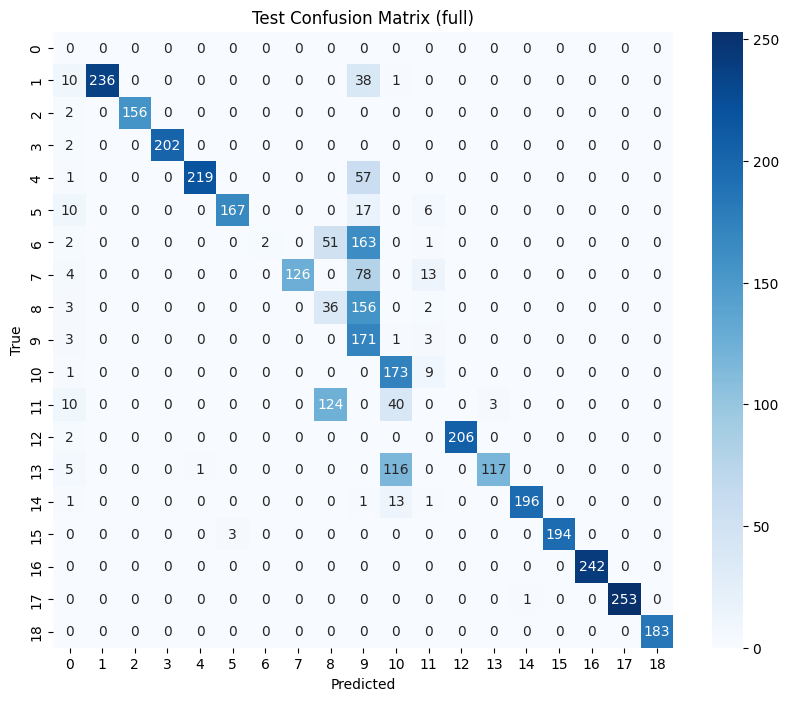

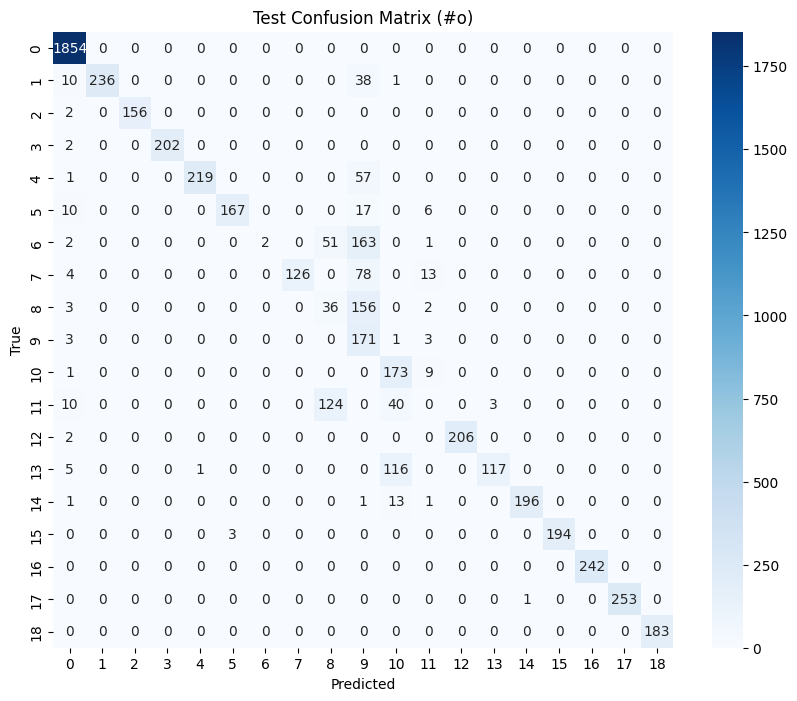

In [34]:
# matrix with label 0
mask = y_test > 0
y_test_filtered = y_test[mask]
y_test_pred_filtered = y_test_pred[mask]

cm = confusion_matrix(y_test_filtered, y_test_pred_filtered)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix (full)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# matrix without label 0
mask = y_test > 0
y_test_filtered = y_test[mask]
y_test_pred_filtered = y_test_pred[mask]

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix (#o)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()